In [21]:
import os
import pandas as pd
import numpy as np
from torchvision.io import read_image
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [11]:
TRAINING_DIR = os.path.join('input', 'train_data')
TRAINING_CSV_DIR = os.path.join('input', 'train.csv')
TESTING_DIR = os.path.join('input', 'test')
TESTING_CSV_DIR = os.path.join('input', 'test2.csv')

In [36]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, train = False, transform=None, download=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.download = download
        self.train = train

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img = self.img_labels.iloc[idx, 1].split('/')[1]
        img_path = os.path.join(self.img_dir, img)
        image = Image.open(img_path).convert('RGB')
        label = self.img_labels.iloc[idx, 2]
        if self.transform:
            image = self.transform(image)
        return image, label

In [37]:
class BasicCNN(nn.Module):
    def __init__(self):
        super(BasicCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3,
                                out_channels=32,
                                kernel_size=3,
                                stride=1,
                                padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2,
                                    stride=2)
        self.conv2 = nn.Conv2d(in_channels=32,
                                out_channels=64,
                                kernel_size=3,
                                stride=1,
                                padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2,
                                    stride=2)
        self.fc = nn.Linear(2359296, 32)
        self.output = nn.Linear(32, 32)

    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = self.output(torch.relu(self.fc(x)))
        nn.Softmax(x)
        return x

In [38]:
device = 'cuda'
model = BasicCNN()
model.to(device)
loss_function = nn.CrossEntropyLoss()

# Check the device of the model
model_device = next(model.parameters()).device
print(f"Model is on device: {model_device}")

Model is on device: cuda:0


In [ ]:
batch_size = 32
transform = transforms.Compose([
    transforms.Resize([768, 768]),
    transforms.ToTensor(), # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.5], std=[0.5]), # Normalize to [0, 1]
])
train_dataset = CustomImageDataset(TRAINING_CSV_DIR, TRAINING_DIR, train=True, transform=transform,
download=True)
test_dataset = CustomImageDataset(TESTING_CSV_DIR, TESTING_DIR, train=False, transform=transform,
download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [40]:
optimizer = optim.Adam(model.parameters(), lr=0.0005)

In [41]:
num_epochs=5
model.train()
losses = []
training_accuracies = []
for epoch in range(num_epochs):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        # Forward pass for both tasks
        output = model(images)
        
        # Calculate individual task losses
        output_loss = loss_function(output, labels)

        # Backpropagation and optimization
        optimizer.zero_grad()
        output_loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {output_loss.item():.4f}')
    losses.append(output_loss.item())

    output_correct, total = 0, 0
    predictions = []
    y_test = []
    accuracies = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            # Forward pass for both tasks
            output = model(images)
            # Calculate output classification accuracy
            _, output = torch.max(output, 1)
            output_correct += (output == labels).sum().item()

            total += labels.size(0)
            y_test.append(labels)
            predictions.append(output)
    test_accuracy = 100 * output_correct / total
    print(f"Epoch {epoch + 1} Output Classification Accuracy: {test_accuracy:.2f}%")
    training_accuracies.append(test_accuracy)
    accuracies.append(test_accuracy)

Epoch [1/5], Loss: 0.2279
Epoch 1 Output Classification Accuracy: 92.55%
Epoch [2/5], Loss: 0.0590
Epoch 2 Output Classification Accuracy: 95.58%
Epoch [3/5], Loss: 0.0206
Epoch 3 Output Classification Accuracy: 91.79%
Epoch [4/5], Loss: 0.0807
Epoch 4 Output Classification Accuracy: 94.40%
Epoch [5/5], Loss: 0.0025
Epoch 5 Output Classification Accuracy: 95.25%


In [ ]:
losses_and_accuracies = pd.DataFrame({'losses': losses, 'test_accuracy': training_accuracies})
losses_and_accuracies.to_csv(os.path.join('output', 'losses_and_accuracies.csv'))

test_vs_pred = pd.DataFrame({'y_test': torch.cat(y_test).cpu(), "predictions": torch.cat(predictions).cpu()})
test_vs_pred.to_csv(os.path.join('output', 'test_vs_pred.csv'))

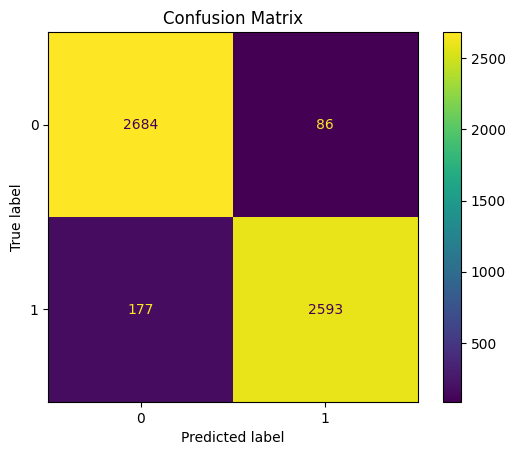

<Figure size 640x480 with 0 Axes>

In [33]:
test_vs_pred = pd.read_csv(os.path.join('output', 'test_vs_pred.csv'))
cm = confusion_matrix(test_vs_pred['y_test'], test_vs_pred['predictions'])
ConfusionMatrixDisplay(cm).plot()
plt.title(f"Confusion Matrix")
plt.show()
plt.savefig(os.path.join('output', 'confusion_matrix.png'))

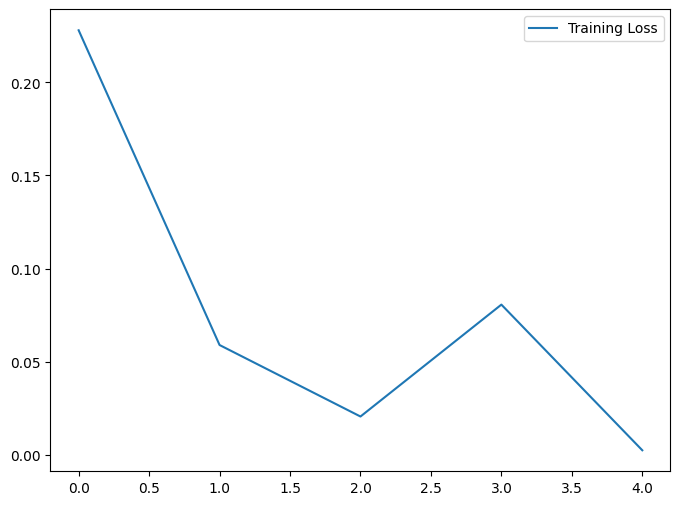

<Figure size 640x480 with 0 Axes>

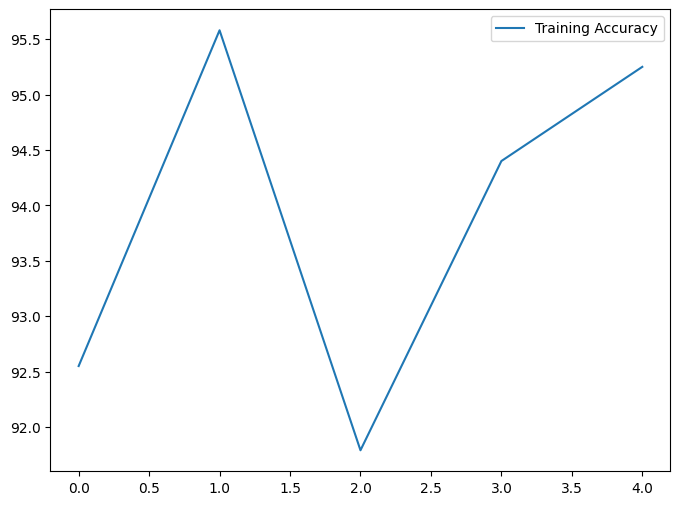

<Figure size 640x480 with 0 Axes>

In [34]:
losses_and_accuracies = pd.read_csv(os.path.join('output', 'losses_and_accuracies.csv'))
plt.figure(figsize=(8, 6))
plt.plot(losses_and_accuracies['losses'], label='Training Loss')
plt.legend()
plt.show()
plt.savefig(os.path.join('output', 'training_loss.png'))
plt.figure(figsize=(8, 6))
plt.plot(losses_and_accuracies['test_accuracy'], label='Training Accuracy')
plt.legend()
plt.show()
plt.savefig(os.path.join('output', 'training_accuracy.png'))

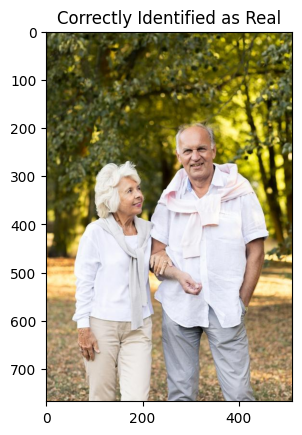

In [35]:
for i in range(len(test_vs_pred['y_test'])):
    if test_vs_pred['y_test'][i] == 0 and test_vs_pred['predictions'][i] == 0:
        img_file = pd.read_csv(TESTING_CSV_DIR).iloc[i, 1].split('/')[1]
        img = np.asarray(Image.open(os.path.join(TESTING_DIR, img_file)))
        plt.title("Correctly Identified as Real")
        plt.imshow(img)
        plt.savefig(os.path.join('output', 'Correctly_Identified_Real.png'))
        break     

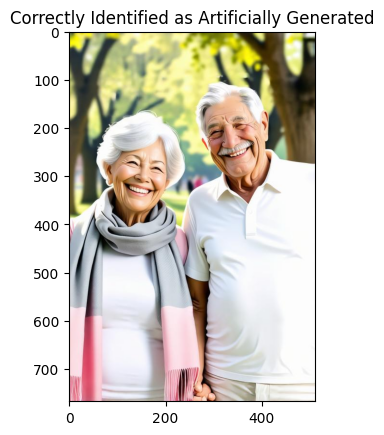

In [36]:
for i in range(len(test_vs_pred['y_test'])):
    if test_vs_pred['y_test'][i] == 1 and test_vs_pred['predictions'][i] == 1:
        img_file = pd.read_csv(TESTING_CSV_DIR).iloc[i, 1].split('/')[1]
        img = np.asarray(Image.open(os.path.join(TESTING_DIR, img_file)))
        plt.title("Correctly Identified as Artificially Generated")
        plt.imshow(img)
        plt.savefig(os.path.join('output', 'Correctly_Identified_AI.png'))
        break     

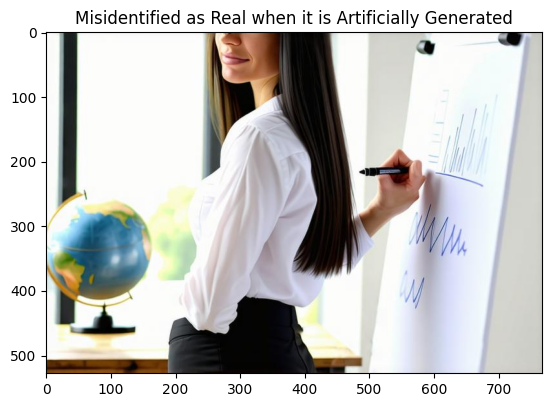

In [37]:
for i in range(len(test_vs_pred['y_test'])):
    if test_vs_pred['y_test'][i] == 1 and test_vs_pred['predictions'][i] == 0:
        img_file = pd.read_csv(TESTING_CSV_DIR).iloc[i, 1].split('/')[1]
        img = np.asarray(Image.open(os.path.join(TESTING_DIR, img_file)))
        plt.title("Misidentified as Real when it is Artificially Generated")
        plt.imshow(img)
        plt.savefig(os.path.join('output', 'Misidentified_Real.png'))
        break     

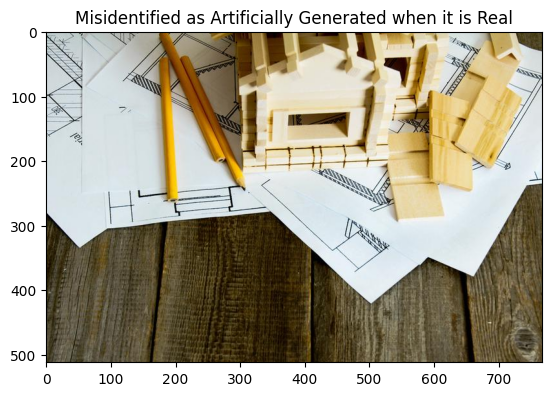

In [38]:
for i in range(len(test_vs_pred['y_test'])):
    if test_vs_pred['y_test'][i] == 0 and test_vs_pred['predictions'][i] == 1:
        img_file = pd.read_csv(TESTING_CSV_DIR).iloc[i, 1].split('/')[1]
        img = np.asarray(Image.open(os.path.join(TESTING_DIR, img_file)))
        plt.title("Misidentified as Artificially Generated when it is Real")
        plt.imshow(img)
        plt.savefig(os.path.join('output', 'Misidentified_AI.png'))
        break     